## 0. Loading Data

In [1]:
import pandas as pd

# Load the CSV file into a DataFrame with low_memory=False to avoid DtypeWarning
data = pd.read_csv('msna_data.csv', low_memory=False)

## 1. Data Exploration

This code performs **explanatory data analysis** (EDA) on a dataset, focusing on correlation analysis, skewness, and variance inflation factor (VIF) for numeric features. It also handles label encoding of categorical variables, cross-tabulation, and hierarchical clustering for visualizing relationships between categories. Finally, the results are exported for further analysis.

**Key Steps:**

1. **Label Encoding for Categorical Variables**:
   - The function `encode_categorical_columns(df)` uses `LabelEncoder` to convert categorical variables into numeric form, ensuring that no NaN values are introduced during conversion. This step is essential for preparing the dataset for correlation and regression analysis.

2. **Correlation and Explanatory Analysis**:
   - The `explanatory_analysis(df, target)` function calculates various statistical metrics for each feature in relation to the target variable, including:
     - **Pearson correlation and p-value**.
     - **Spearman correlation and p-value**.
     - **Kendall's Tau correlation and p-value**.
     - **Skewness**: To measure asymmetry in the distribution of each feature.
     - **Variance Inflation Factor (VIF)**: To detect multicollinearity between features.

3. **Cross-Tabulation**:
   - A **cross-tabulation** of the `msna` categories and the target variable (`child_sep_severity_family_reun_required`) is created to analyze the proportion of the target values within each category.

4. **Hierarchical Clustering**:
   - **Hierarchical clustering** is performed using the `ward` linkage method on the cross-tabulated data to group `msna` categories based on the distribution of the target variable.
   - A **dendrogram** is plotted to visualize the relationships between the clusters of `msna` categories.

5. **Data Visualization**:
   - A bar plot visualizes the frequency distribution of the `msna` categories.
   - A dendrogram visualizes the hierarchical clustering of the `msna` categories based on the target distribution.

6. **Exporting Results**:
   - The correlation analysis table is saved as an Excel file (`eda_corr_table.xlsx`) for further review or documentation.

                                         Variable  Pearson Correlation  \
60    child_sep_severity_all_family_reun_required             1.000000   
6                         children_outside_hh_all             0.225001   
5                             children_outside_hh             0.225001   
9                         child_sep_reasons_given             0.225001   
57                    children_outside_hh_all_yes             0.225001   
..                                            ...                  ...   
54                         children_outside_hh_no            -0.225001   
56                     children_outside_hh_all_no            -0.225001   
61  child_sep_severity_all_no_children_outside_hh            -0.225001   
8                          child_sep_severity_all            -0.459017   
7                              child_sep_severity            -0.459017   

    Pearson P-Value  Spearman Correlation  Spearman P-Value  \
60              0.0              1.000000       

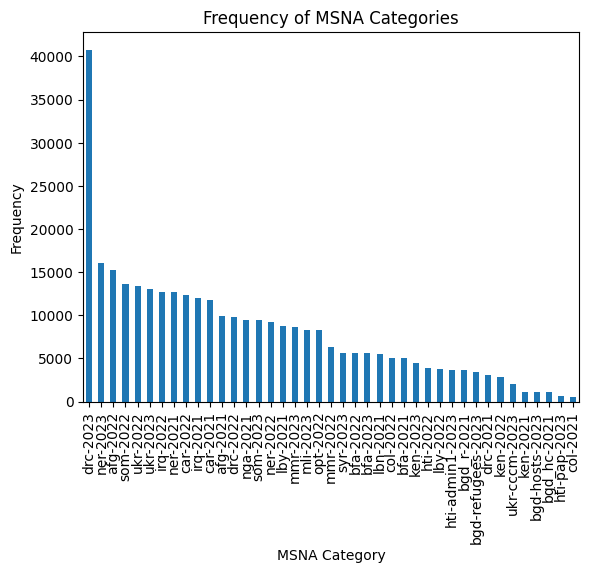

Explanatory Test: Cross-tabulation of msna categories and target values
child_sep_severity_family_reun_required       0.0       1.0
msna                                                       
afg-2021                                 0.999262  0.000738
afg-2022                                 0.999869  0.000131
bfa-2021                                 0.996712  0.003288
bfa-2022                                 0.997073  0.002927
bfa-2023                                 0.997325  0.002675
bgd-hosts-2023                           1.000000  0.000000
bgd-refugees-2023                        0.997026  0.002974
bgd_hc-2021                              0.999040  0.000960
bgd_r-2021                               0.999707  0.000293
car-2021                                 0.958882  0.041118
car-2022                                 0.995492  0.004508
col-2022                                 0.999729  0.000271
drc-2021                                 0.996414  0.003586
drc-2022                    

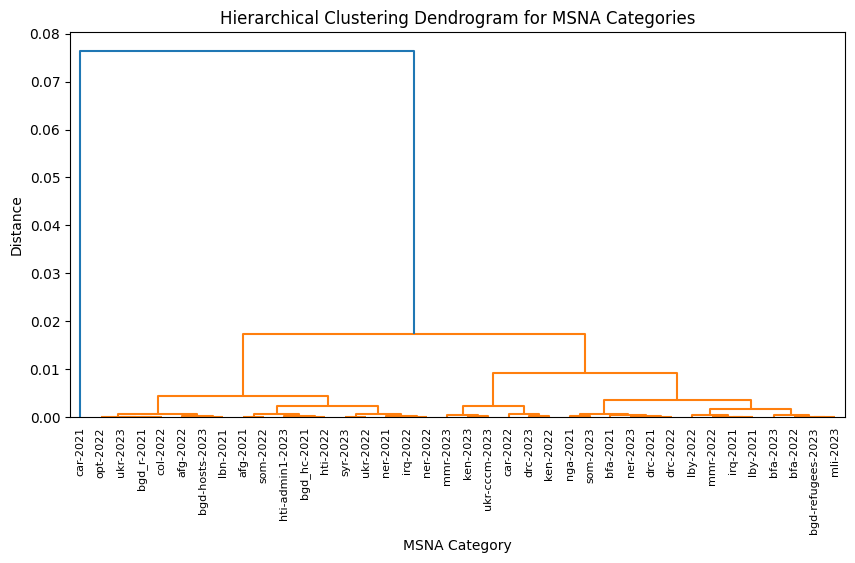

In [3]:
import missingno as msno
import matplotlib.pyplot as plt
import scipy.stats as stats
from sklearn.preprocessing import LabelEncoder
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import AgglomerativeClustering
from scipy.stats import pearsonr, spearmanr, kendalltau, skew
from statsmodels.stats.outliers_influence import variance_inflation_factor
import numpy as np
import pandas as pd

# Label encode any categorical variables to ensure no NaNs during conversion
label_encoder = LabelEncoder()

# Apply label encoding to categorical columns before converting them to numeric
def encode_categorical_columns(df):
    for col in df.select_dtypes(include=['object', 'category']).columns:
        df[col] = label_encoder.fit_transform(df[col].astype(str))
    return df

# Apply encoding to categorical columns
encoded_data = encode_categorical_columns(data.copy())

# Now convert to numeric (this step will not introduce NaNs because categorical columns are now encoded)
numeric_data = encoded_data.apply(pd.to_numeric, errors='coerce')

# Function to calculate correlations, p-values, and other explanatory metrics
def explanatory_analysis(df, target):
    variables = df.columns[df.columns != target]
    results = {
        'Variable': [],
        'Pearson Correlation': [],
        'Pearson P-Value': [],
        'Spearman Correlation': [],
        'Spearman P-Value': [],
        'Kendall Tau Correlation': [],
        'Kendall P-Value': [],
        'Skewness': [],
        'Variance Inflation Factor (VIF)': []
    }

    for col in variables:
        clean_df = df[[col, target]].dropna()

        # Check if the column has enough variability (at least 2 unique values)
        if len(clean_df) >= 2 and clean_df[col].nunique() > 1 and clean_df[target].nunique() > 1:
            # Pearson correlation and p-value
            pearson_corr, pearson_p = pearsonr(clean_df[col], clean_df[target])

            # Spearman correlation and p-value (only if there's variability)
            spearman_corr, spearman_p = spearmanr(clean_df[col], clean_df[target]) if clean_df[col].nunique() > 1 else (np.nan, np.nan)

            # Kendall's Tau correlation and p-value (only if there's variability)
            kendall_corr, kendall_p = kendalltau(clean_df[col], clean_df[target]) if clean_df[col].nunique() > 1 else (np.nan, np.nan)

            # Skewness (calculate only if variability exists)
            skewness = skew(clean_df[col]) if clean_df[col].nunique() > 1 else np.nan

            # VIF calculation (handled similarly)
            try:
                vif = variance_inflation_factor(df.dropna().values, df.columns.get_loc(col))
            except:
                vif = np.nan  # Handle cases where VIF cannot be computed

            # Append results to the appropriate lists
            results['Variable'].append(col)
            results['Pearson Correlation'].append(pearson_corr)
            results['Pearson P-Value'].append(pearson_p)
            results['Spearman Correlation'].append(spearman_corr)
            results['Spearman P-Value'].append(spearman_p)
            results['Kendall Tau Correlation'].append(kendall_corr)
            results['Kendall P-Value'].append(kendall_p)
            results['Skewness'].append(skewness)
            results['Variance Inflation Factor (VIF)'].append(vif)

    # Return the results as a DataFrame
    return pd.DataFrame(results).sort_values(by='Pearson Correlation', ascending=False)

# Apply the function for explanatory analysis on all numeric variables
explanatory_table = explanatory_analysis(numeric_data, 'child_sep_severity_family_reun_required')

# Print the explanatory analysis table
print(explanatory_table)

# Export the DataFrame to an Excel file
explanatory_table.to_excel("eda_corr_table.xlsx", index=False)

# Check the frequency of each category in 'msna'
msna_freq = data['msna'].value_counts()

# Print the frequency of each category in msna
print("Frequency of each category in 'msna':")
print(msna_freq)

# Visualize the distribution of msna categories
msna_freq.plot(kind='bar')
plt.title('Frequency of MSNA Categories')
plt.xlabel('MSNA Category')
plt.ylabel('Frequency')
plt.show()

# Cross-tabulation of msna categories and target values
print("Explanatory Test: Cross-tabulation of msna categories and target values")
target_dist_by_msna = pd.crosstab(data['msna'], data['child_sep_severity_family_reun_required'], normalize='index')
print(target_dist_by_msna)

# Check the structure of the input data (proportion of target variable for each msna category)
print("Explanatory Test: Structure of the input data (proportion of target variable for each msna category)")
print(target_dist_by_msna.head())

# Perform hierarchical clustering using the linkage matrix
linkage_matrix = linkage(target_dist_by_msna, method='ward')

# Plot the dendrogram to visualize category clustering
plt.figure(figsize=(10, 5))
dendrogram(linkage_matrix, labels=target_dist_by_msna.index, leaf_rotation=90)
plt.title('Hierarchical Clustering Dendrogram for MSNA Categories')
plt.xlabel('MSNA Category')
plt.ylabel('Distance')
plt.show()

## 2. Data Cleaning

This script performs **data cleaning** by handling missing values and irrelevant columns in a dataset. Key steps include:

1. **Defining a Function for Conditional Column Removal**:
   - A function is created to drop columns based on specific conditions, such as missing values or zero variance.

2. **Filtering Rows with Missing Values**:
   - Rows where the column `child_sep_severity` has missing values are removed.

3. **Selecting Pre-Specified Variables**:
   - A list of variables from `vars_analysis.csv` is loaded and used to select columns present in the dataset.

4. **Dropping Irrelevant or Problematic Columns**:
   - Columns with more than 20% missing values are dropped.
   - Columns with zero variance and those ending with '_NA' are removed.

5. **Missing Data Visualization**:
   - Before and after the column removals, missing data is visualized using `missingno`.

6. **Displaying Final Data Information**:
   - The final DataFrame structure is shown after the data cleaning steps.

This process helps ensure that the dataset is prepared for further analysis or modeling.



Shape of the filtered DataFrame, without missing values for the response variable: (268511, 199)

Dropped columns with more than 20% missing values:
['lcsi_cat', 'hoh_age', 'rcsi_score', 'fsl_fc_cell', 'wgq_dis_4_n', 'wgq_dis_3_n', 'wgq_dis_2_n', 'fatalities_3m', 'events_3m', 'fatalities_6m', 'events_6m', 'fatalities_1y', 'events_1y', 'displ_status_specific_idp_non_site', 'displ_status_specific_idp_returnee', 'displ_status_specific_idp_site', 'received_assistance_3m_dnk', 'received_assistance_3m_dwta', 'received_assistance_3m_no', 'received_assistance_3m_yes', 'received_assistance_6m_dnk', 'received_assistance_6m_dwta', 'received_assistance_6m_no', 'received_assistance_6m_yes', 'received_assistance_12m_dnk', 'received_assistance_12m_dwta', 'received_assistance_12m_no', 'received_assistance_12m_yes']

Dropped columns '_NA' columns:
['displ_status_general_NA', 'displ_status_specific_NA', 'hoh_gender_NA', 'single_caregiver_NA', 'received_assistance_3m_NA', 'received_assistance_6m_NA', 'r

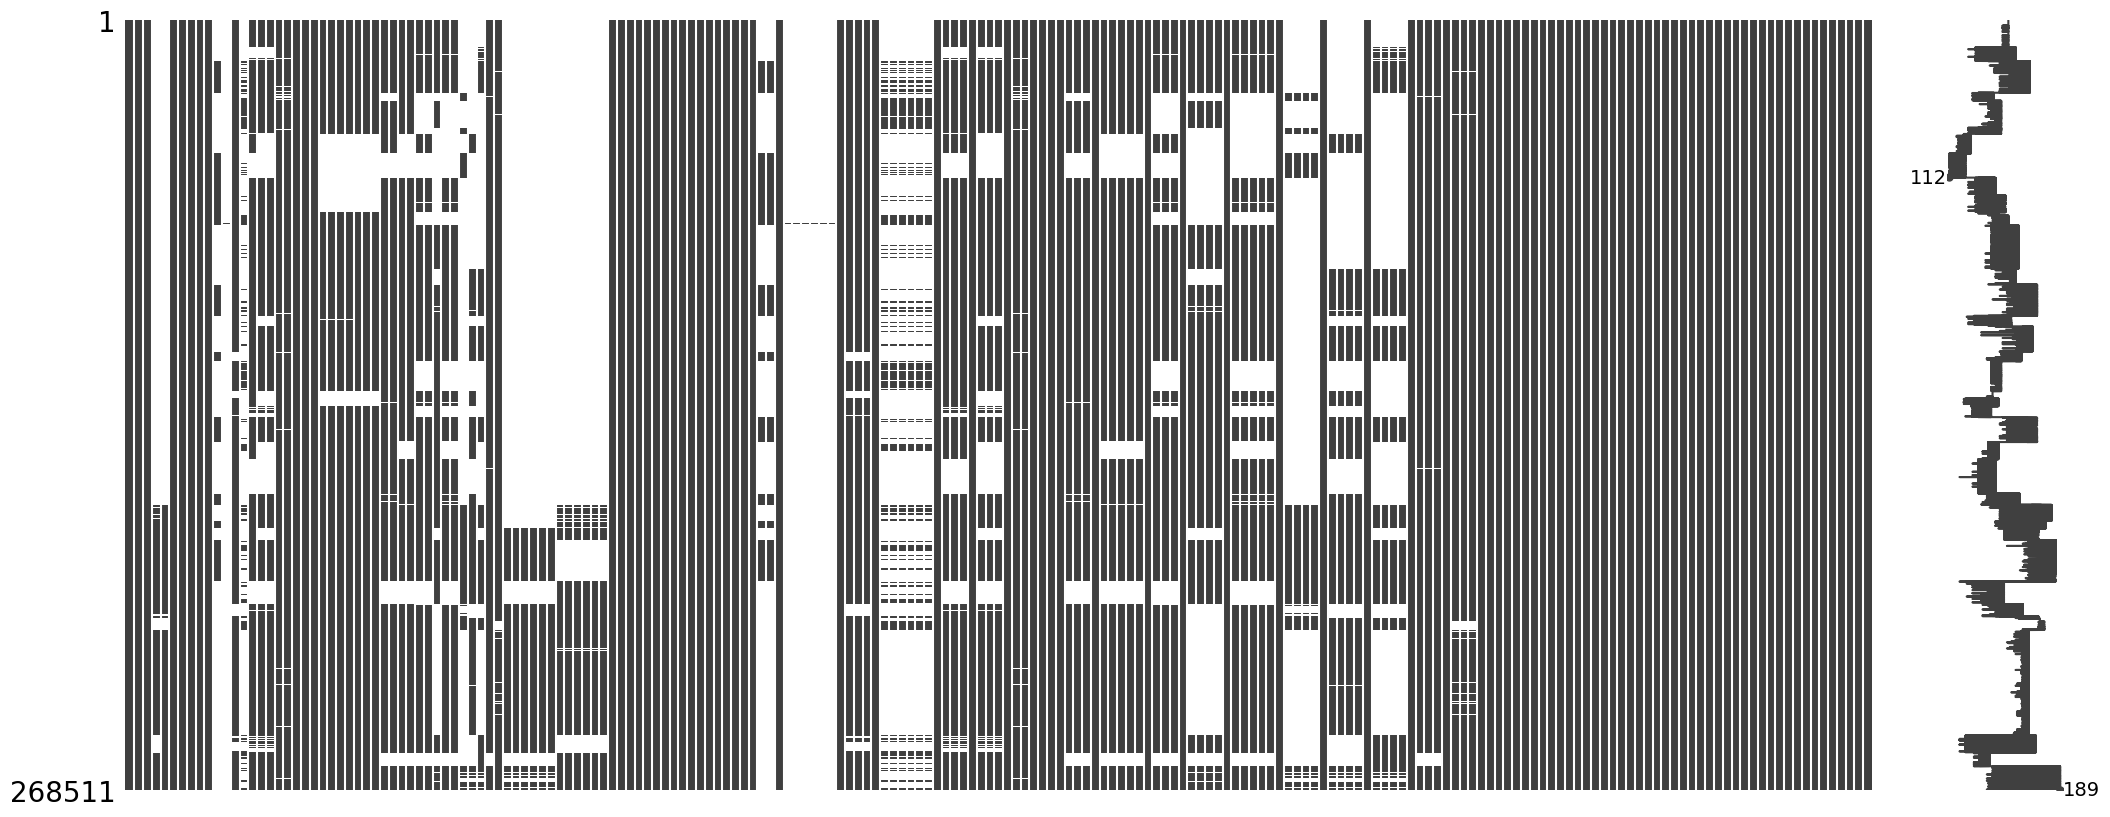

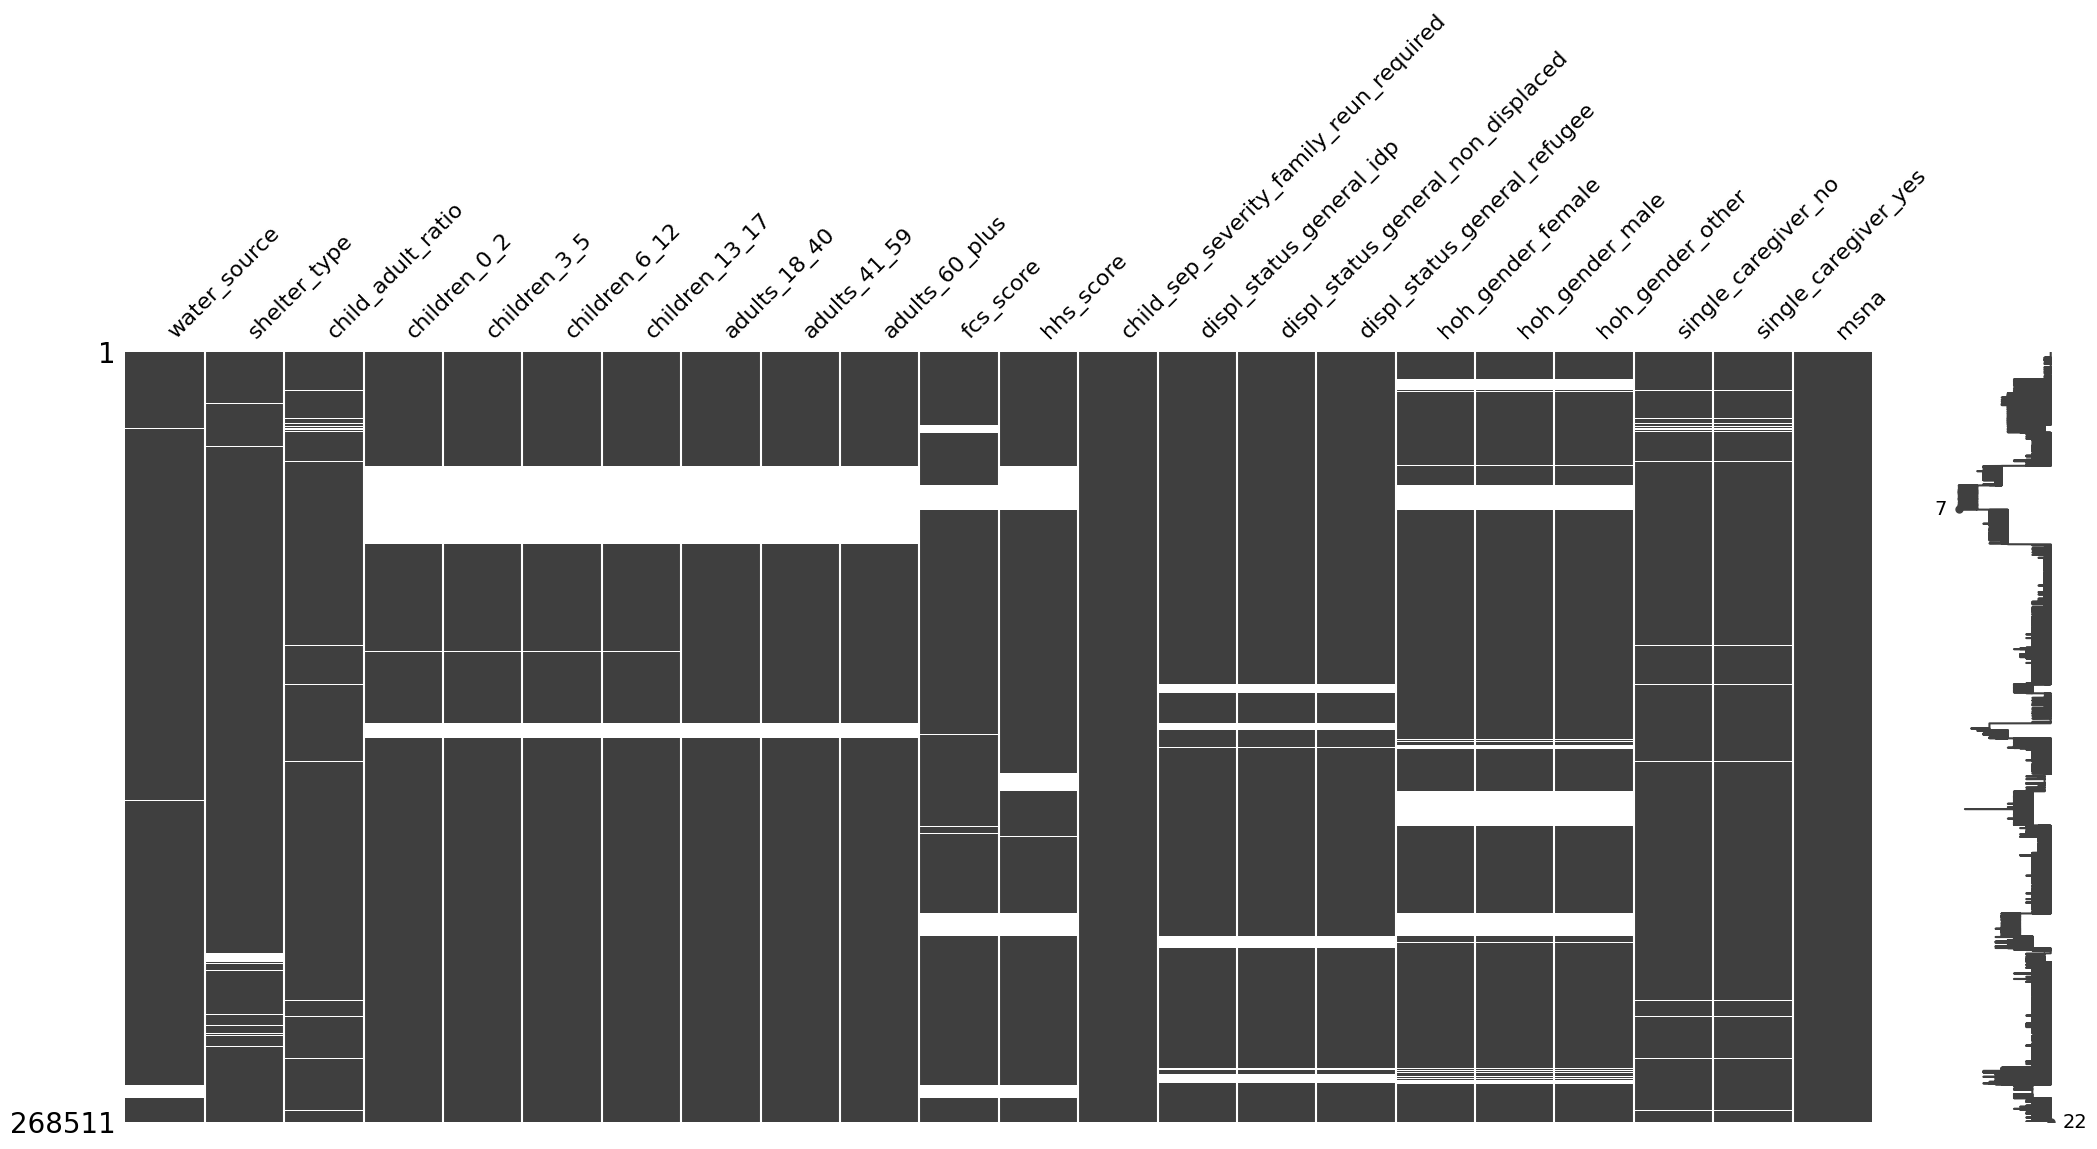


Final DataFrame after dropping unnecessary columns:
<class 'pandas.core.frame.DataFrame'>
Index: 268511 entries, 0 to 329442
Data columns (total 22 columns):
 #   Column                                   Non-Null Count   Dtype  
---  ------                                   --------------   -----  
 0   water_source                             263014 non-null  object 
 1   shelter_type                             262333 non-null  object 
 2   child_adult_ratio                        264081 non-null  float64
 3   children_0_2                             235209 non-null  float64
 4   children_3_5                             235209 non-null  float64
 5   children_6_12                            235209 non-null  float64
 6   children_13_17                           235209 non-null  float64
 7   adults_18_40                             235498 non-null  float64
 8   adults_41_59                             235498 non-null  float64
 9   adults_60_plus                           235498 non-nul

In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import missingno as msno

# Define function to display and drop columns based on a condition
def drop_columns_with_condition(df, condition, description):
    columns_to_drop = df.columns[condition].tolist()
    if columns_to_drop:
        print(f"\nDropped columns {description}:")
        print(columns_to_drop)
        return df.drop(columns=columns_to_drop)
    return df

# Filter out rows with missing values in the 'child_sep_severity' column
data_filtered = data.dropna(subset=['child_sep_severity'])
print("\nShape of the filtered DataFrame, without missing values for the response variable:", data_filtered.shape)

# Load variables to consider for the model
vars_analysis = pd.read_csv('vars_analysis.csv')['variable'].tolist()

# Select columns that were pre-selected for analysis and present in the dataset
data_select = data_filtered[vars_analysis].copy()

# Exclude the two aggregated age variables
aggregate_features = ['num_children', 'num_adults']
data_select = data_select.drop(columns=aggregate_features, errors='ignore')

# Identify columns with more than 20% missing values
missing_percentage = data_select.isnull().mean() * 100
columns_with_many_missing = missing_percentage > 20

# Drop columns with more than 20% missing values
data_select = drop_columns_with_condition(data_select, columns_with_many_missing, "with more than 20% missing values")

# Drop columns with zero variance (only one unique value)
zero_variance_condition = data_select.nunique() <= 1
data_select = drop_columns_with_condition(data_select, zero_variance_condition, "with zero variance")

# Identify and drop variables ending with '_NA'
na_columns = [col for col in data_select.columns if col.endswith('_NA')]
data_select = drop_columns_with_condition(data_select, data_select.columns.isin(na_columns), "'_NA' columns")

# Visualize missing data matrix before and after dropping columns
msno.matrix(data_filtered)
plt.show()
msno.matrix(data_select)
plt.show()

# Display final DataFrame info
print("\nFinal DataFrame after dropping unnecessary columns:")
data_select.info()


## 3. Data Transformation and Feature Engineering 

In [17]:
import pandas as pd
from sklearn.cluster import AgglomerativeClustering

# Load the new_labels CSV file and filter for variables present in the data
new_labels = pd.read_csv('new_labels.csv', usecols=['variable', 'label_old', 'label_new'])
new_labels = new_labels[new_labels['variable'].isin(data_select.columns)]

# Create a copy of data_select to apply changes
data_trans = data_select.copy()

# Apply the label mapping to the data_trans DataFrame
for _, row in new_labels.iterrows():
    variable = row['variable']
    label_old = row['label_old']
    label_new = int(row['label_new'])  # Convert label_new to integer
    
    if variable in data_trans.columns:
        data_trans[variable] = data_trans[variable].replace(label_old, label_new)

# Define recoded_variables
recoded_variables = new_labels['variable'].unique()

# Convert the recoded variables to integer type
for variable in recoded_variables:
    if variable in data_trans.columns:
        data_trans[variable] = data_trans[variable].fillna(pd.NA).astype('Int64')

# Clustering MSNA variables using AgglomerativeClustering
n_clusters = 5
cluster_model = AgglomerativeClustering(n_clusters=n_clusters, metric='euclidean', linkage='ward')
msna_clusters = cluster_model.fit_predict(target_dist_by_msna)

# Create a DataFrame to show the MSNA categories and their corresponding clusters
clustered_df = pd.DataFrame({'msna': target_dist_by_msna.index, 'cluster': msna_clusters})

# Map cluster assignments back to the original DataFrame
msna_cluster_map = clustered_df.set_index('msna')['cluster'].to_dict()
data_trans['msna_clustered'] = data_trans['msna'].map(msna_cluster_map)

# Replace the original 'msna' column and One-hot encode the 'msna' column
data_trans['msna'] = data_trans['msna_clustered']
data_trans = data_trans.drop(columns=['msna_clustered'])
data_trans = pd.get_dummies(data_trans, columns=['msna'], prefix='msna', dtype=int)

print("\nTransformed DataFrame after label encoding and clustering:")
print(data_trans.head())


Transformed DataFrame after label encoding and clustering:
   water_source  shelter_type  child_adult_ratio  children_0_2  children_3_5  \
0             1             1                0.2           0.0           0.0   
1             1             1                2.5           0.0           1.0   
3             1             1                2.0           1.0           1.0   
4             1             1                2.0           0.0           0.0   
6             2             1                2.5           0.0           2.0   

   children_6_12  children_13_17  adults_18_40  adults_41_59  adults_60_plus  \
0            0.0             1.0           3.0           2.0             0.0   
1            4.0             0.0           1.0           1.0             0.0   
3            2.0             0.0           2.0           0.0             0.0   
4            4.0             0.0           1.0           1.0             0.0   
6            2.0             1.0           0.0           2.

C:\Users\jasper.linke\AppData\Local\Temp\ipykernel_22452\3136967616.py:18: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data_trans[variable] = data_trans[variable].replace(label_old, label_new)


## 4. Imputation of Missing Values


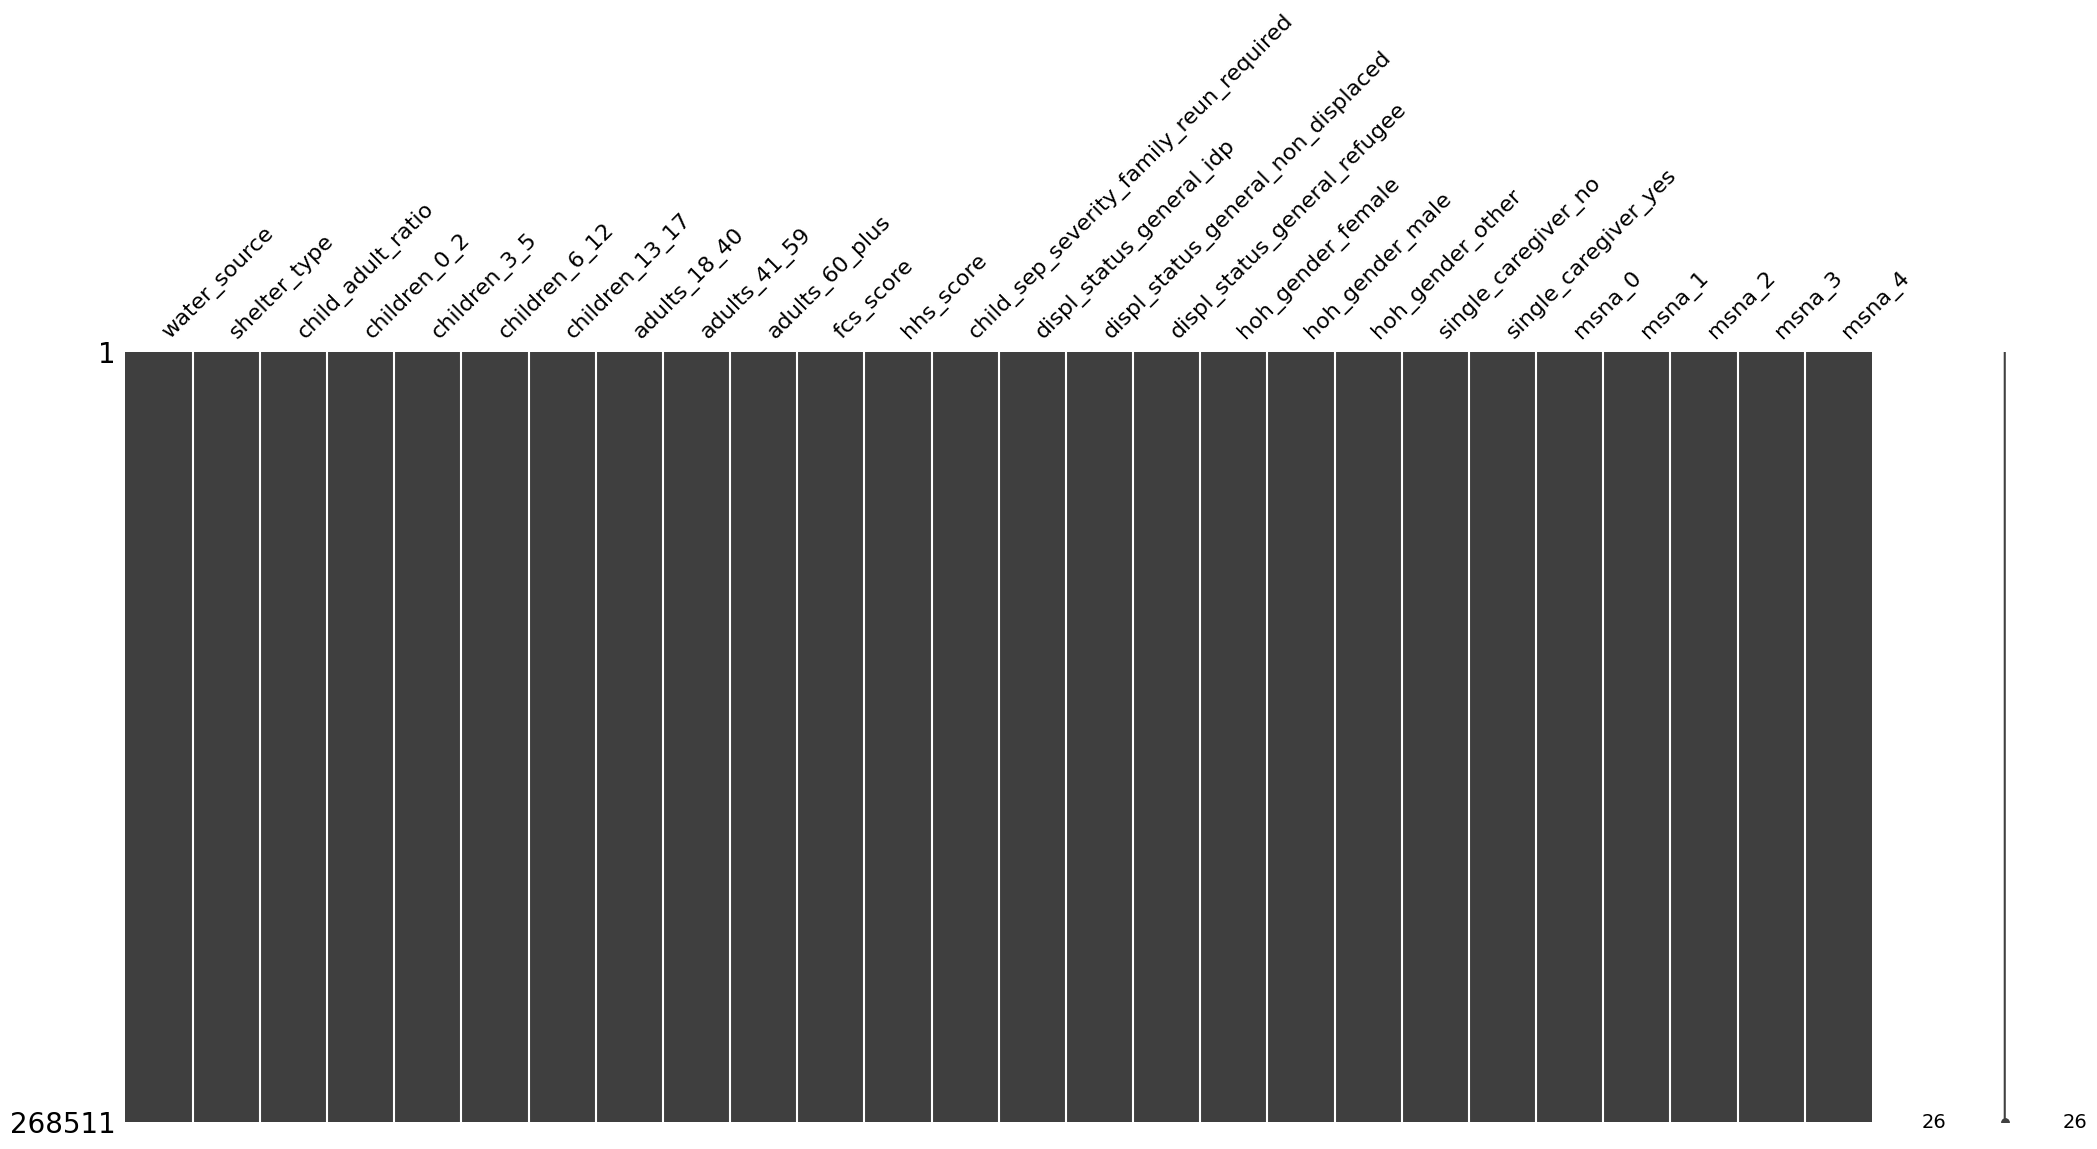


DataFrame with imputed values:
   water_source  shelter_type  child_adult_ratio  children_0_2  children_3_5  \
0           1.0           1.0                0.2           0.0           0.0   
1           1.0           1.0                2.5           0.0           1.0   
2           1.0           1.0                2.0           1.0           1.0   
3           1.0           1.0                2.0           0.0           0.0   
4           2.0           1.0                2.5           0.0           2.0   

   children_6_12  children_13_17  adults_18_40  adults_41_59  adults_60_plus  \
0            0.0             1.0           3.0           2.0             0.0   
1            4.0             0.0           1.0           1.0             0.0   
2            2.0             0.0           2.0           0.0             0.0   
3            4.0             0.0           1.0           1.0             0.0   
4            2.0             1.0           0.0           2.0             0.0   

   ...

In [18]:
import pandas as pd
import pickle
from sklearn.impute import KNNImputer
import missingno as msno
import matplotlib.pyplot as plt

# Function to apply K-Nearest Neighbors Imputation to all columns
def knn_impute_all_columns(df, n_neighbors=5):
    imputer = KNNImputer(n_neighbors=n_neighbors)
    df_imputed = pd.DataFrame(imputer.fit_transform(df), columns=df.columns)
    return df_imputed

# Apply KNN imputation to all columns
data_na_imp = knn_impute_all_columns(data_trans.copy())

# Visualize missing data matrix after imputation
msno.matrix(data_na_imp)
plt.show()

# Display the first few rows of the new dataframe with imputed values
print("\nDataFrame with imputed values:")
print(data_na_imp.head())

# Saving the DataFrame as a pickle file
with open('data_na_imp.pkl', 'wb') as f:
    pickle.dump(data_na_imp, f)


## 5. Data Standardization


Summary statistics before standardization:
        water_source   shelter_type  child_adult_ratio   children_0_2  \
count  268511.000000  268511.000000      268511.000000  268511.000000   
mean        1.303494       1.240512           1.517225       0.458774   
std         0.576704       0.441943           1.122010       0.666187   
min         1.000000       1.000000           0.035714       0.000000   
25%         1.000000       1.000000           0.666667       0.000000   
50%         1.000000       1.000000           1.333333       0.000000   
75%         1.000000       1.000000           2.000000       1.000000   
max         3.000000       3.000000          14.000000      12.000000   

        children_3_5  children_6_12  children_13_17   adults_18_40  \
count  268511.000000  268511.000000   268511.000000  268511.000000   
mean        0.623481       1.424800        0.768818       1.841805   
std         0.732188       1.238367        0.914277       1.159341   
min         0.0000

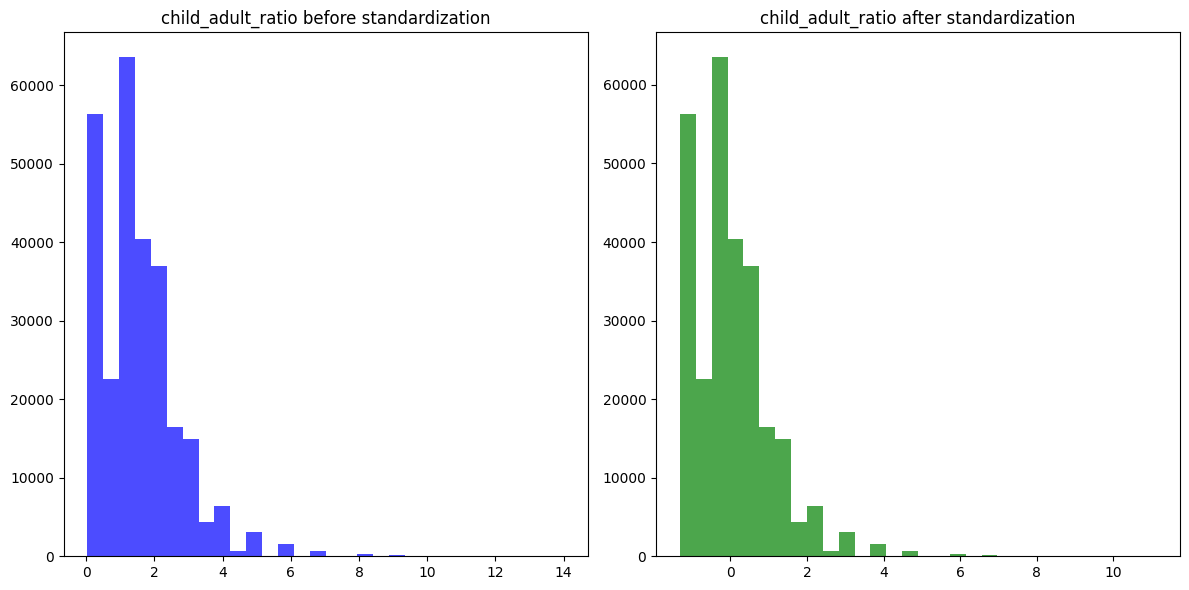

In [23]:
import pandas as pd
import pickle
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Loading the DataFrame back from the pickle file
with open('data_na_imp.pkl', 'rb') as f:
    loaded_data_pickle = pickle.load(f)
    
# Load the vars_analysis.csv to identify variable types
vars_analysis = pd.read_csv('vars_analysis.csv', usecols=['variable', 'type'])
numerical_variables = vars_analysis[vars_analysis['type'] == 'numerical']['variable'].tolist()

# Filter numerical variables that are present in the DataFrame
numerical_variables = [var for var in numerical_variables if var in data_stand.columns]

# Standardize the numerical variables
scaler = StandardScaler()
data_stand = data_na_imp.copy()

# Apply standardization only to numerical variables
data_stand[numerical_variables] = scaler.fit_transform(data_stand[numerical_variables])

# Display summary statistics before and after standardization
print("\nSummary statistics before standardization:")
print(data_na_imp.describe())
print("\nSummary statistics after standardization:")
print(data_stand.describe())

# Display histograms before and after standardization
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.hist(data_na_imp['child_adult_ratio'], bins=30, alpha=0.7, color='blue')
plt.title('child_adult_ratio before standardization')

plt.subplot(1, 2, 2)
plt.hist(data_stand['child_adult_ratio'], bins=30, alpha=0.7, color='green')
plt.title('child_adult_ratio after standardization')
plt.tight_layout()
plt.show()

## 6. Feature Selection

[LightGBM] [Info] Number of positive: 793, number of negative: 187164
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007985 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 715
[LightGBM] [Info] Number of data points in the train set: 187957, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000


100%|===================| 187633/187957 [07:46<00:00]        

Shape of SHAP values (list length): 187957
Shape of SHAP values for class 0: (23,)
Shape of SHAP values for class 1: (23,)


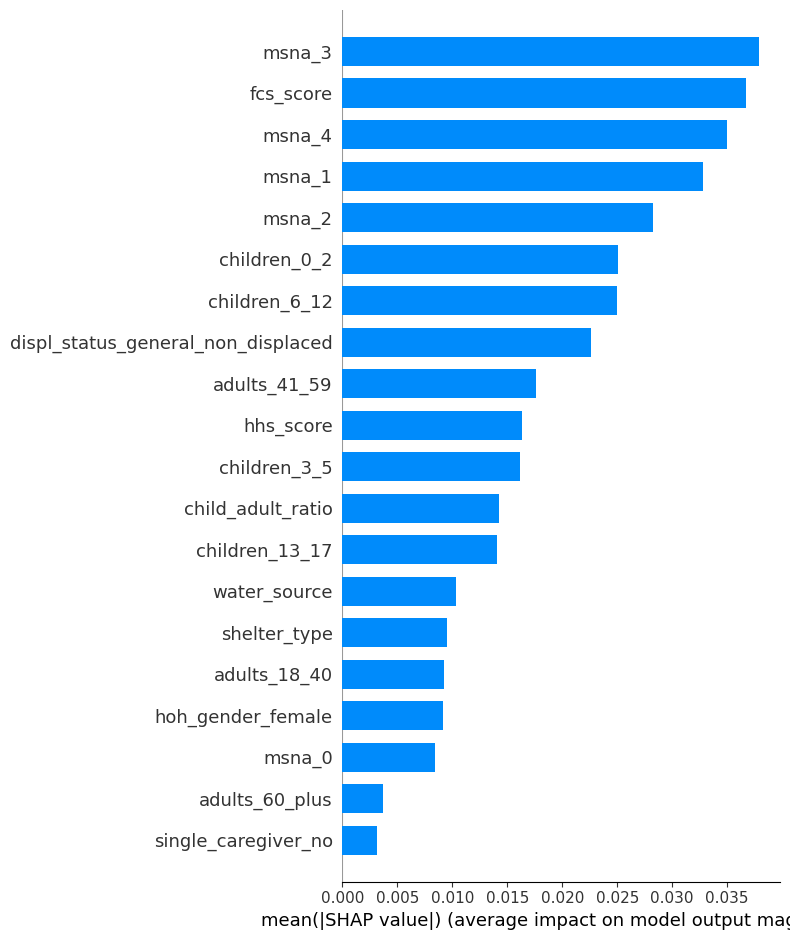

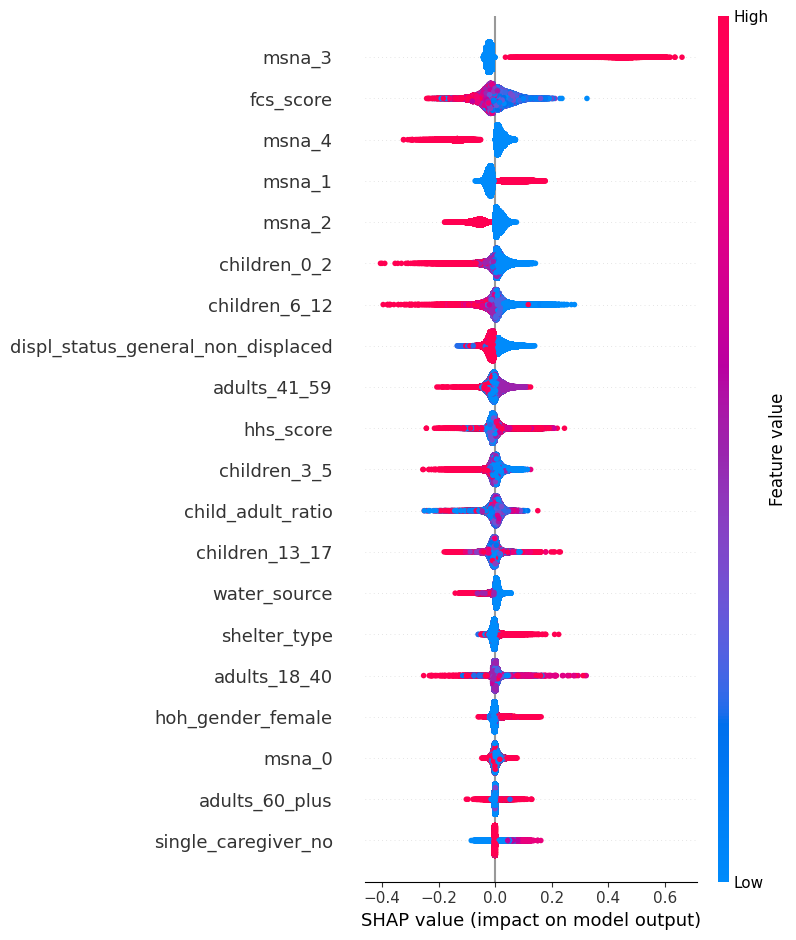

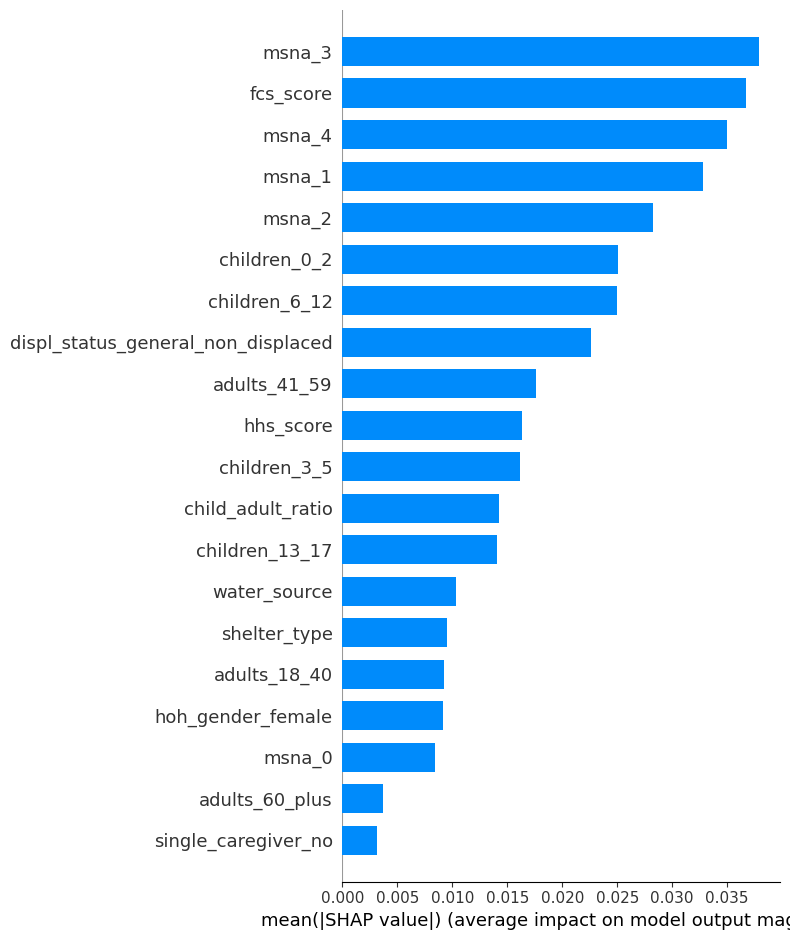

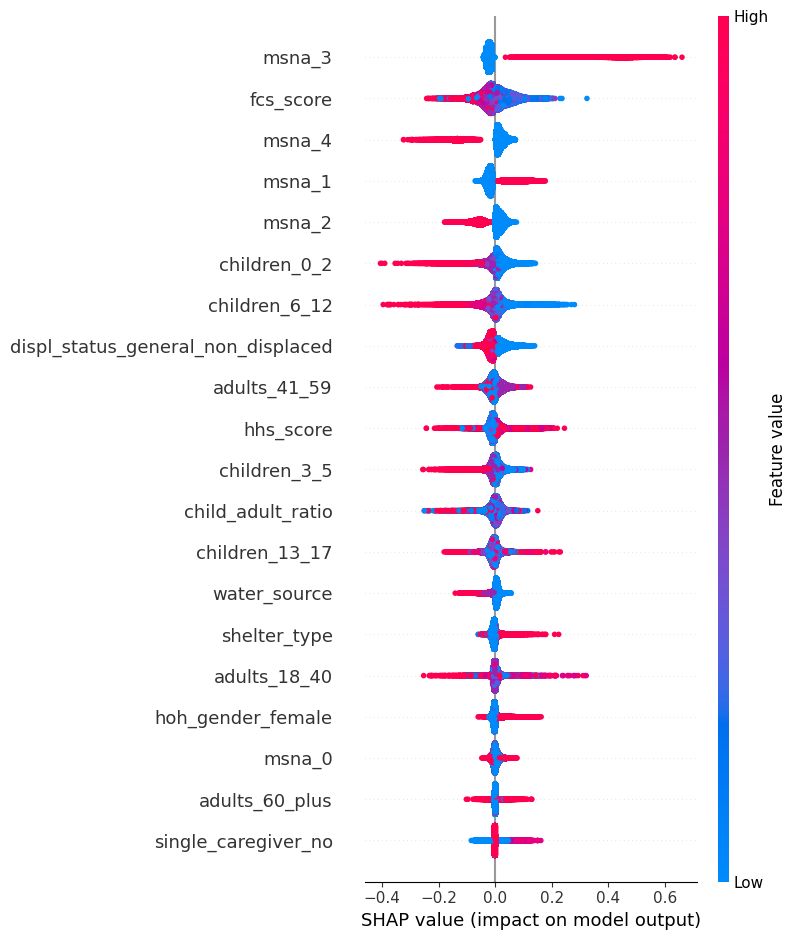

In [35]:
import pandas as pd
import numpy as np
import lightgbm as lgb
import shap
import pickle
from sklearn.model_selection import train_test_split

# Create a copy of data_stand for feature selection
data_fs = data_stand.copy()

# Separate features and target variable
X = data_fs.drop(columns=['child_sep_severity_family_reun_required'], errors='ignore')
y = data_fs['child_sep_severity_family_reun_required']

# Ensure input data is correct (numeric, no missing values)
def check_numeric(df):
    if not all(df.dtypes.apply(lambda x: np.issubdtype(x, np.number))):
        raise ValueError("All features must be numeric. Please convert categorical variables to numeric format.")

def check_no_missing(df):
    if df.isnull().any().any():
        raise ValueError("Input data contains missing values. Please handle missing data before applying these methods.")

check_numeric(X)
check_no_missing(X)

# Correlation Analysis to remove highly correlated features
corr_matrix = X.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

correlation_threshold = 0.9
to_drop = [column for column in upper.columns if any(upper[column] > correlation_threshold)]
X_uncorr = X.drop(columns=to_drop)

# Train-test split for SHAP analysis
X_temp_train, X_temp_test, y_temp_train, y_temp_test = train_test_split(X_uncorr, y, test_size=0.3, random_state=42, stratify=y)

# Train a LightGBM model for SHAP analysis
lgb_model = lgb.LGBMClassifier(random_state=42, class_weight='balanced')
lgb_model.fit(X_temp_train, y_temp_train)

# Compute SHAP values with TreeExplainer and model_output='probability'
explainer = shap.TreeExplainer(lgb_model, data=X_temp_train, model_output='probability')
shap_values = explainer.shap_values(X_temp_train)

# Use shap_values directly for the summary plot (SHAP will handle it internally)
print(f"Shape of SHAP values (list length): {len(shap_values)}")
print(f"Shape of SHAP values for class 0: {shap_values[0].shape}")
print(f"Shape of SHAP values for class 1: {shap_values[1].shape}")

# SHAP summary plots for all classes
shap.summary_plot(shap_values, X_temp_train, plot_type="bar", max_display=num_top_features)
shap.summary_plot(shap_values, X_temp_train, max_display=num_top_features)

# Calculate SHAP feature importance
mean_abs_shap_values = np.abs(shap_values_selected).mean(axis=0)
shap_importance = pd.DataFrame({
    'feature': X_uncorr.columns,
    'shap_importance': mean_abs_shap_values
})
shap_importance.sort_values(by='shap_importance', ascending=False, inplace=True)

# Select top features based on SHAP values
num_top_features = 20
top_features_shap = shap_importance['feature'].head(num_top_features).tolist()
X_selected = X_uncorr[top_features_shap]

# Save selected features and target
with open('X_selected.pkl', 'wb') as f:
    pickle.dump(X_selected, f)
with open('y.pkl', 'wb') as f:
    pickle.dump(y, f)

# SHAP summary plots for the selected SHAP values (for the positive class)
shap.summary_plot(shap_values_selected, X_temp_train, plot_type="bar", max_display=num_top_features)
shap.summary_plot(shap_values_selected, X_temp_train, max_display=num_top_features)


## 7. Data Splitting

In [36]:
import pickle
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

# Load the saved DataFrames
with open('X_selected.pkl', 'rb') as f:
    X_selected = pickle.load(f)
with open('y.pkl', 'rb') as f:
    y = pickle.load(f)

### 1. Separate the Data into Class 0 (Normal) and Class 1 (Anomalies) ###

# Create DataFrames for class 0 (normal cases) and class 1 (anomalies)
X_class0 = X_selected[y == 0]
y_class0 = y[y == 0]

X_class1 = X_selected[y == 1]
y_class1 = y[y == 1]

print(f"Total samples in Class 0 (Normal): {X_class0.shape[0]}")
print(f"Total samples in Class 1 (Anomalies): {X_class1.shape[0]}")

### 2. Split Class 0 Data into Training, Validation, and Test Sets ###

# Split class 0 data into training (80%) and temporary set (20%)
X_train_class0, X_temp_class0, y_train_class0, y_temp_class0 = train_test_split(
    X_class0, y_class0, test_size=0.2, random_state=42
)

# Further split the temporary class 0 data into validation (10%) and test (10%) sets
X_val_class0, X_test_class0, y_val_class0, y_test_class0 = train_test_split(
    X_temp_class0, y_temp_class0, test_size=0.5, random_state=42
)

print("\nClass 0 Data Splits:")
print(f"  Training samples: {X_train_class0.shape[0]}")
print(f"  Validation samples: {X_val_class0.shape[0]}")
print(f"  Test samples: {X_test_class0.shape[0]}")

### 3. Split Class 1 Data into Validation and Test Sets ###

# Since we don't use anomalies for training, split class 1 data into validation and test sets
# We'll split equally, but you can adjust the proportion as needed
X_val_class1, X_test_class1, y_val_class1, y_test_class1 = train_test_split(
    X_class1, y_class1, test_size=0.5, random_state=42
)

print("\nClass 1 Data Splits:")
print(f"  Validation samples: {X_val_class1.shape[0]}")
print(f"  Test samples: {X_test_class1.shape[0]}")

### 4. Combine Class 0 and Class 1 Data for Validation and Test Sets ###

# Validation Set: Combine class 0 and class 1 validation data
X_val = pd.concat([X_val_class0, X_val_class1])
y_val = pd.concat([y_val_class0, y_val_class1])

# Test Set: Combine class 0 and class 1 test data
X_test = pd.concat([X_test_class0, X_test_class1])
y_test = pd.concat([y_test_class0, y_test_class1])

# Save the validation and test data as pickle files
with open('X_val.pkl', 'wb') as f:
    pickle.dump(X_val, f)
with open('y_val.pkl', 'wb') as f:
    pickle.dump(y_val, f)
with open('X_test.pkl', 'wb') as f:
    pickle.dump(X_test, f)
with open('y_test.pkl', 'wb') as f:
    pickle.dump(y_test, f)

# Ensure the indices are aligned
X_val.reset_index(drop=True, inplace=True)
y_val.reset_index(drop=True, inplace=True)
X_test.reset_index(drop=True, inplace=True)
y_test.reset_index(drop=True, inplace=True)

### 5. Set Training Data (Only Class 0) ###

X_train = X_train_class0
y_train = y_train_class0

# Save the training data as pickle files
with open('X_train.pkl', 'wb') as f:
    pickle.dump(X_train, f)
with open('y_train.pkl', 'wb') as f:
    pickle.dump(y_train, f)

### 6. Print the Structure of the Resulting Splits ###

print("\nTraining Set (Only Class 0 - Normal Cases)")
print(f"  Features: {X_train.shape[1]}")
print(f"  Samples: {X_train.shape[0]}")
print(f"  Class 0: {np.sum(y_train == 0)}")
print(f"  Class 1: {np.sum(y_train == 1)}")  # Should be 0

print("\nValidation Set (Class 0 and Class 1)")
print(f"  Features: {X_val.shape[1]}")
print(f"  Samples: {X_val.shape[0]}")
print(f"  Class 0: {np.sum(y_val == 0)}")
print(f"  Class 1: {np.sum(y_val == 1)}")

print("\nTest Set (Class 0 and Class 1)")
print(f"  Features: {X_test.shape[1]}")
print(f"  Samples: {X_test.shape[0]}")
print(f"  Class 0: {np.sum(y_test == 0)}")
print(f"  Class 1: {np.sum(y_test == 1)}")


Total samples in Class 0 (Normal): 267378
Total samples in Class 1 (Anomalies): 1133

Class 0 Data Splits:
  Training samples: 213902
  Validation samples: 26738
  Test samples: 26738

Class 1 Data Splits:
  Validation samples: 566
  Test samples: 567

Training Set (Only Class 0 - Normal Cases)
  Features: 20
  Samples: 213902
  Class 0: 213902
  Class 1: 0

Validation Set (Class 0 and Class 1)
  Features: 20
  Samples: 27304
  Class 0: 26738
  Class 1: 566

Test Set (Class 0 and Class 1)
  Features: 20
  Samples: 27305
  Class 0: 26738
  Class 1: 567


## 8. Model Selection, Training, and Evaluation

This script handles the selection, training, and evaluation of anomaly detection models using the **training** and **validation** sets.

**Key Steps**:

- **Data Loading and Preprocessing**:
  - Loads the training set (**X_train**, **y_train**) and validation set (**X_val**, **y_val**) from pickle files.
  - Scales the features using `StandardScaler` to ensure compatibility with the anomaly detection models.

- **Model Training and Hyperparameter Tuning**:
  - Defines three models: **IsolationForest**, **OneClassSVM**, and **LocalOutlierFactor**.
  - Utilizes `GridSearchCV` with **StratifiedKFold** cross-validation to optimize model parameters for the **F1 score**.
  - Hyperparameters are fine-tuned across different configurations to handle the highly imbalanced data.

- **Model Evaluation**:
  - Evaluates each model on the **validation set**.
  - Metrics used include **Precision-Recall AUC**, **classification report**, and **confusion matrix**.
  - The best-performing model is saved to a pickle file for future testing.

- **Model Saving**:
  - The best model (e.g., **IsolationForest**) is saved as `final_model.pkl` for further use in the testing script.

In [39]:
import pickle
import numpy as np
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from sklearn.neighbors import LocalOutlierFactor
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve, auc
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler

# Load and preprocess data
def load_data():
    with open('X_train.pkl', 'rb') as f:
        X_train = pickle.load(f)
    with open('y_train.pkl', 'rb') as f:
        y_train = pickle.load(f)
    with open('X_val.pkl', 'rb') as f:
        X_val = pickle.load(f)
    with open('y_val.pkl', 'rb') as f:
        y_val = pickle.load(f)
    return X_train, y_train, X_val, y_val

# Preprocess data: scaling
def preprocess_data(X_train, X_val):
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)
    return X_train_scaled, X_val_scaled

# Cross-validation using StratifiedKFold for imbalanced datasets
def stratified_cv():
    return StratifiedKFold(n_splits=3)

# Train and tune models using GridSearchCV
def train_and_tune_models(X_train, y_train, skf):
    models = {
        'isolation_forest': IsolationForest(random_state=42),
        'one_class_svm': OneClassSVM(kernel='rbf', gamma='scale'),
        'local_outlier_factor': LOFWrapper()
    }
    
    param_grids = {
        'isolation_forest': {
            'model__n_estimators': [100, 200],
            'model__max_samples': ['auto', 0.6, 0.8],
            'model__contamination': [0.003, 0.005, 0.01],
        },
        'one_class_svm': {
            'model__nu': [0.003, 0.005, 0.01],
            'model__kernel': ['rbf', 'sigmoid'],
            'model__gamma': ['scale', 'auto']
        },
        'local_outlier_factor': {
            'model__n_neighbors': [10, 20, 30],
            'model__contamination': [0.003, 0.005, 0.01],
            'model__algorithm': ['auto', 'kd_tree']
        }
    }

    trained_models = {}
    for model_name, model in models.items():
        print(f"Training {model_name}...")
        pipeline = Pipeline([('scaler', StandardScaler()), ('model', model)])
        grid_search = GridSearchCV(
            estimator=pipeline,
            param_grid=param_grids[model_name],
            scoring='f1_macro',  # Optimizing for F1 score on imbalanced data
            cv=skf,
            n_jobs=-1,
            verbose=1
        )
        grid_search.fit(X_train, y_train)
        trained_models[model_name] = grid_search.best_estimator_
        print(f"Best parameters for {model_name}: {grid_search.best_params_}")
    
    return trained_models

# Evaluate models on validation set
def evaluate_models(trained_models, X_val, y_val):
    for model_name, model in trained_models.items():
        print(f"Evaluating {model_name} on validation data...")
        y_pred = model.predict(X_val)
        # Convert -1 anomaly predictions to 1 (anomaly class)
        y_pred = np.where(y_pred == -1, 1, 0)

        # Precision-Recall AUC
        precision, recall, _ = precision_recall_curve(y_val, y_pred)
        auc_pr = auc(recall, precision)
        print(f"Precision-Recall AUC for {model_name}: {auc_pr}")

        print(classification_report(y_val, y_pred, digits=4))
        print(confusion_matrix(y_val, y_pred))

# Save the final model
def save_model(final_model, path):
    with open(path, 'wb') as f:
        pickle.dump(final_model, f)

# Main flow
if __name__ == '__main__':
    # Load and preprocess the data
    X_train, y_train, X_val, y_val = load_data()
    X_train, X_val = preprocess_data(X_train, X_val)

    # Perform stratified cross-validation and model training
    skf = stratified_cv()
    trained_models = train_and_tune_models(X_train, y_train, skf)

    # Evaluate models on validation set
    evaluate_models(trained_models, X_val, y_val)

    # Save the best performing model (you can adjust based on your model performance)
    final_model = trained_models['isolation_forest']  # Change as needed
    save_model(final_model, 'final_model.pkl')


Training isolation_forest...
Fitting 3 folds for each of 18 candidates, totalling 54 fits
Best parameters for isolation_forest: {'model__contamination': 0.003, 'model__max_samples': 'auto', 'model__n_estimators': 100}
Training one_class_svm...
Fitting 3 folds for each of 12 candidates, totalling 36 fits
Best parameters for one_class_svm: {'model__gamma': 'scale', 'model__kernel': 'rbf', 'model__nu': 0.003}
Training local_outlier_factor...
Fitting 3 folds for each of 18 candidates, totalling 54 fits
Best parameters for local_outlier_factor: {'model__algorithm': 'auto', 'model__contamination': 0.003, 'model__n_neighbors': 10}
Evaluating isolation_forest on validation data...
Precision-Recall AUC for isolation_forest: 0.08032022095707868
              precision    recall  f1-score   support

         0.0     0.9796    0.9970    0.9882     26738
         1.0     0.1209    0.0194    0.0335       566

    accuracy                         0.9767     27304
   macro avg     0.5502    0.5082    

## 9. Model Testing an Final Evaluation

This script loads the trained model from the previous script and evaluates it on the **test** dataset, applying threshold tuning and generating SHAP explainability visualizations.

**Key Steps**:

- **Data Loading**:
  - Loads the saved model (**final_model.pkl**) and the **test dataset** (**X_test**, **y_test**) from pickle files.

- **Model Testing and Threshold Tuning**:
  - The model makes predictions on the test set.
  - Uses **Precision-Recall AUC** for performance evaluation.
  - Threshold tuning is performed to find the best **F1 score** for anomaly detection.

- **Evaluation**:
  - Generates a **classification report** and **confusion matrix** to assess performance on the test data.
  - Applies **SHAP** for both global and local explainability:
    - **Global summary plot** for feature importance.
    - **Local force plot** for specific anomaly explanations.

- **Explainability with SHAP**:
  - SHAP values are calculated and visualized for model interpretability.
  - Outputs **SHAP summary plots** and **force plots** for deeper insights into model predictions.

c:\Users\jasper.linke\Python-Projects\child_sep_ml\.venv\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
c:\Users\jasper.linke\Python-Projects\child_sep_ml\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\jasper.linke\Python-Projects\child_sep_ml\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\jasper.linke\Python-Projects\child_sep_ml\.venv\Lib\site-packages\sklearn\metrics\_class

Best threshold for F1 score: 0
Precision-Recall AUC on test data: 0.026862170329484007
              precision    recall  f1-score   support

         0.0     0.0000    0.0000    0.0000     26738
         1.0     0.0208    1.0000    0.0407       567

    accuracy                         0.0208     27305
   macro avg     0.0104    0.5000    0.0203     27305
weighted avg     0.0004    0.0208    0.0008     27305

[[    0 26738]
 [    0   567]]


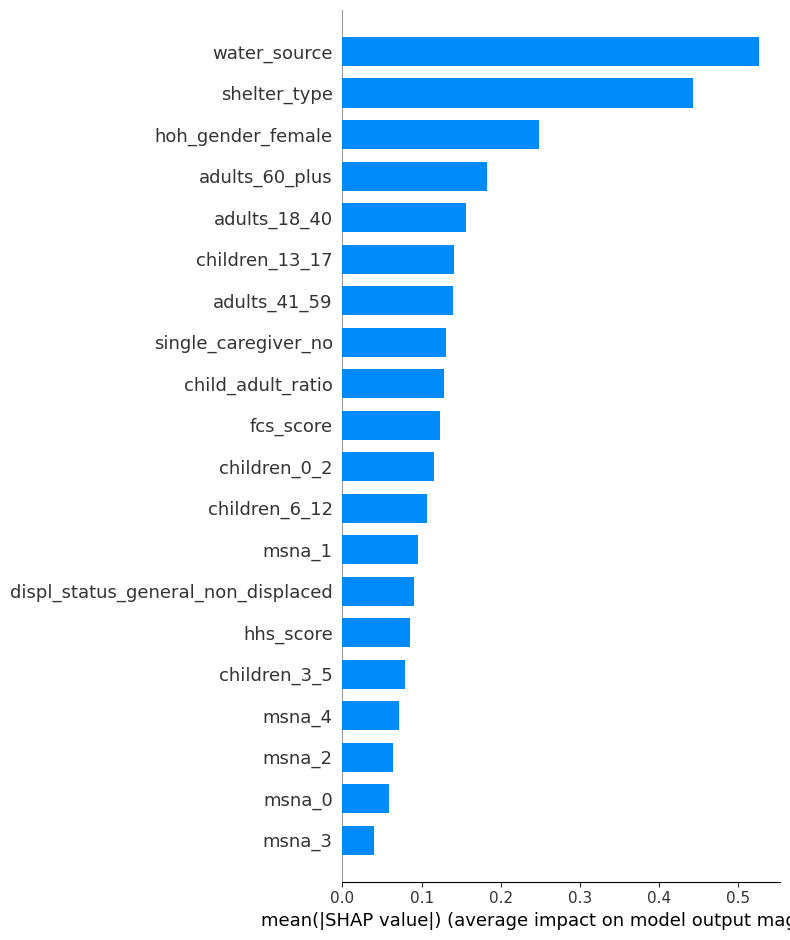

<Figure size 640x480 with 0 Axes>

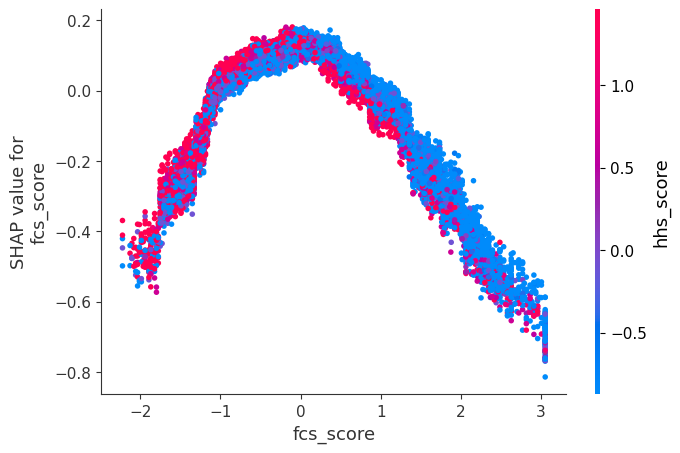

<Figure size 640x480 with 0 Axes>

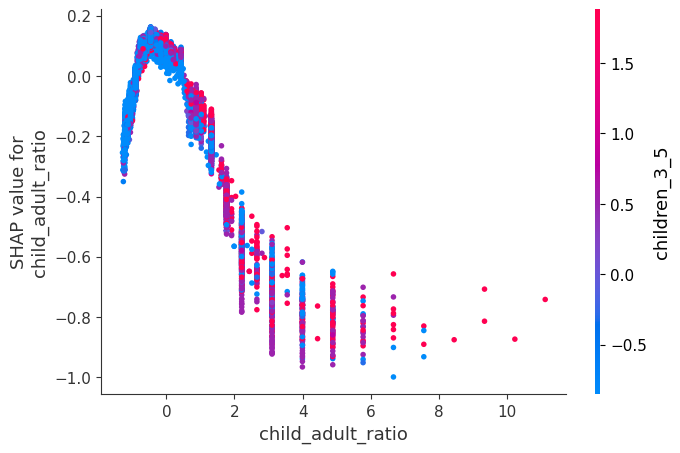

<Figure size 640x480 with 0 Axes>

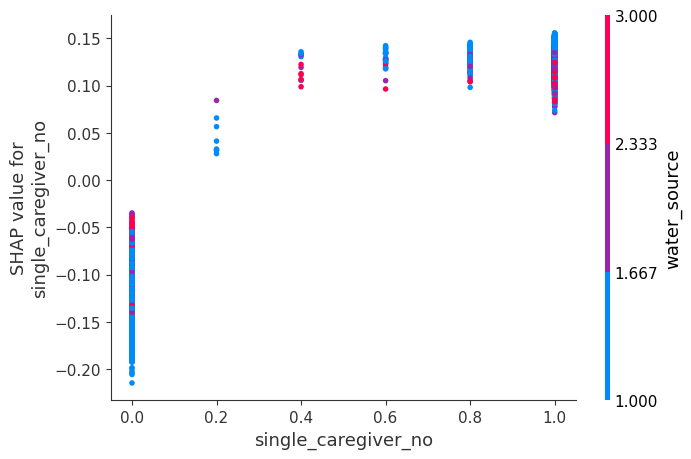

<Figure size 640x480 with 0 Axes>

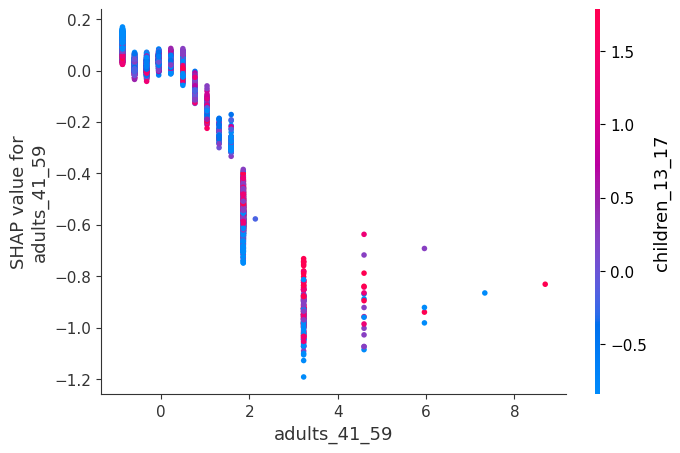

<Figure size 640x480 with 0 Axes>

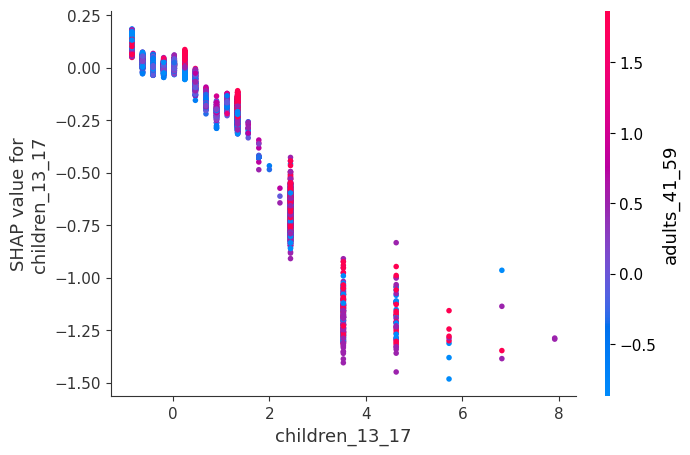

<Figure size 640x480 with 0 Axes>

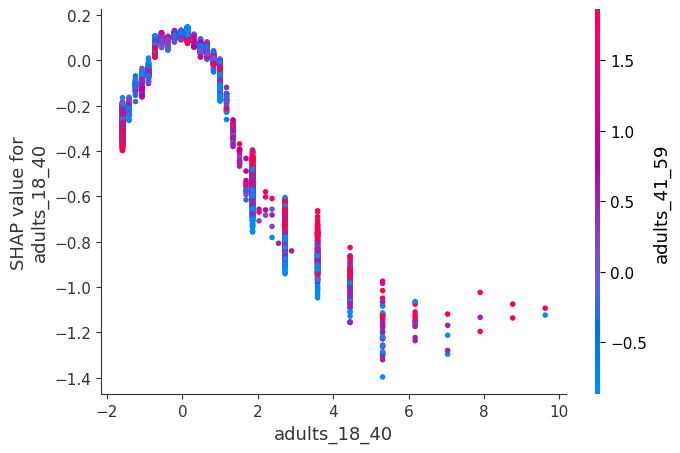

<Figure size 640x480 with 0 Axes>

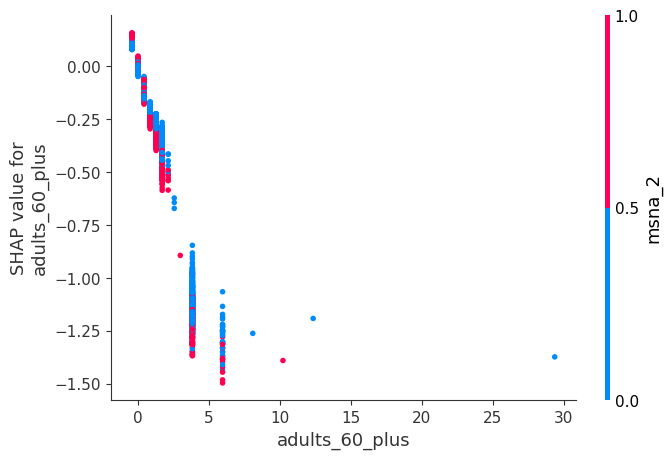

<Figure size 640x480 with 0 Axes>

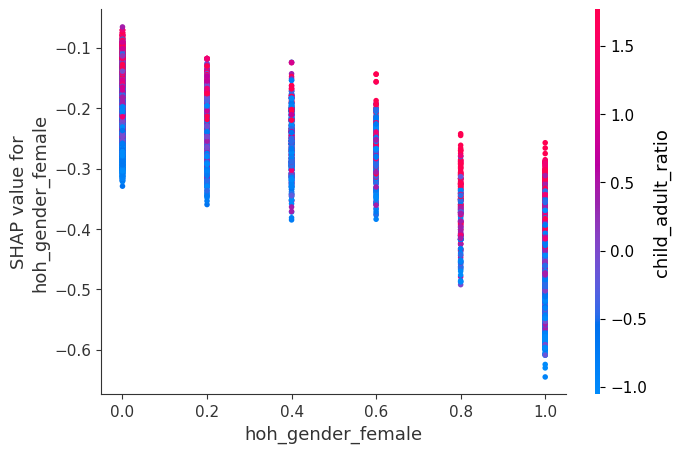

<Figure size 640x480 with 0 Axes>

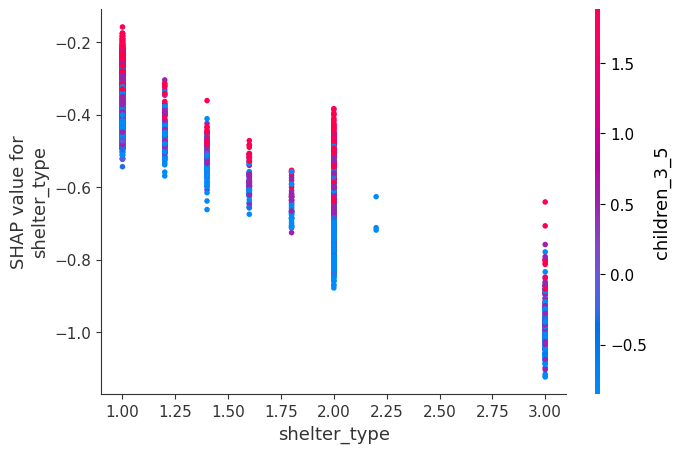

<Figure size 640x480 with 0 Axes>

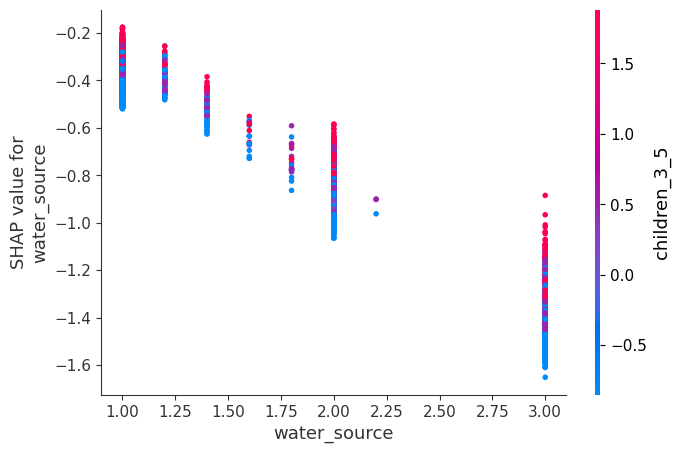

In [48]:
import pickle
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve, auc
import shap
import matplotlib.pyplot as plt

# Load the saved model
def load_model(path):
    with open(path, 'rb') as f:
        model = pickle.load(f)
    return model

# Load test data
def load_test_data():
    with open('X_test.pkl', 'rb') as f:
        X_test = pickle.load(f)
    with open('y_test.pkl', 'rb') as f:
        y_test = pickle.load(f)
    return X_test, y_test

# Test the model on the test data
def test_model(model, X_test, y_test):
    # Predict using the test set
    y_pred = model.predict(X_test)
    y_pred = np.where(y_pred == -1, 1, 0)  # Convert -1 to 1 (anomalies)
    
    # Threshold tuning for the best F1 score
    precision, recall, thresholds = precision_recall_curve(y_test, y_pred)
    f1_scores = 2 * (precision * recall) / (precision + recall)
    best_threshold = thresholds[np.argmax(f1_scores)]
    print(f"Best threshold for F1 score: {best_threshold}")

    # Calculate precision-recall AUC
    auc_pr = auc(recall, precision)
    print(f"Precision-Recall AUC on test data: {auc_pr}")

    # Final evaluation with best threshold
    y_pred_final = (y_pred >= best_threshold).astype(int)
    print(classification_report(y_test, y_pred_final, digits=4))
    print(confusion_matrix(y_test, y_pred_final))

# Generate SHAP plots and save them to PNG files
def explain_with_shap(pipeline, X_test):
    # Extract the model from the pipeline
    model = pipeline.named_steps['model']  # Access IsolationForest from the pipeline
    
    # Use a Tree explainer for tree-based models like IsolationForest
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X_test)

    # Global SHAP summary plot
    plt.figure()
    shap.summary_plot(shap_values, X_test, plot_type="bar", show=False)
    plt.show()  # Display the plot
    plt.savefig("shap_summary_plot.png", bbox_inches="tight")
    plt.close()

    # Extract the top 10 most important features from the summary plot
    top_features = np.argsort(np.mean(np.abs(shap_values), axis=0))[-10:]  # Top 10 feature indices

    # Generate SHAP dependence plots for the top 10 most important features
    for i, feature_index in enumerate(top_features):
        plt.figure()
        shap.dependence_plot(feature_index, shap_values, X_test, show=False)
        plt.show()  # Display the plot
        plt.savefig(f"shap_dependence_plot_feature_{feature_index}.png", bbox_inches="tight")
        plt.close()

# Main flow
if __name__ == '__main__':
    # Load the final model and test data
    final_model = load_model('final_model.pkl')
    X_test, y_test = load_test_data()

    # Test the model on the test data
    test_model(final_model, X_test, y_test)

    # Explain model predictions using SHAP and generate dependence plots
    explain_with_shap(final_model, X_test)






## 10. Interpretation